In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class FERDataProcessor:
    """
    Data processing class for Facial Expression Recognition dataset
    """
    
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.images_path = os.path.join(dataset_path, 'images')
        self.annotations_path = os.path.join(dataset_path, 'annotations')
        self.expression_labels = {
            0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Surprise',
            4: 'Fear', 5: 'Disgust', 6: 'Anger', 7: 'Contempt'
        }
        
    def load_annotations(self, image_id):
        """Load annotations for a specific image"""
        try:
            exp_file = os.path.join(self.annotations_path, f'{image_id}_exp.npy')
            val_file = os.path.join(self.annotations_path, f'{image_id}_val.npy')
            aro_file = os.path.join(self.annotations_path, f'{image_id}_aro.npy')
            
            expression = np.load(exp_file)
            valence = np.load(val_file)
            arousal = np.load(aro_file)
            
            return expression, valence, arousal
        except:
            return None, None, None
    
    def load_image(self, image_id, target_size=(224, 224)):
        """Load and preprocess image"""
        image_path = os.path.join(self.images_path, f'{image_id}.jpg')
        if not os.path.exists(image_path):
            return None
            
        image = cv2.imread(image_path)
        if image is None:
            return None
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        return image
    
    def load_dataset(self, max_samples=None):
        """Load complete dataset"""
        images = []
        expressions = []
        valences = []
        arousals = []
        image_ids = []
        
        # Get all image files
        image_files = [f for f in os.listdir(self.images_path) if f.endswith('.jpg')]
        image_ids_available = [int(f.split('.')[0]) for f in image_files]
        image_ids_available.sort()
        
        if max_samples:
            image_ids_available = image_ids_available[:max_samples]
        
        print(f"Loading {len(image_ids_available)} images...")
        
        for i, image_id in enumerate(image_ids_available):
            if i % 1000 == 0:
                print(f"Processed {i}/{len(image_ids_available)} images")
                
            # Load image
            image = self.load_image(image_id)
            if image is None:
                continue
                
            # Load annotations
            exp, val, aro = self.load_annotations(image_id)
            if exp is None:
                continue
                
            # Filter out invalid annotations
            if val == -2 or aro == -2:  # Uncertain or No-face categories
                continue
                
            images.append(image)
            expressions.append(int(exp))
            valences.append(float(val))
            arousals.append(float(aro))
            image_ids.append(image_id)
        
        print(f"Successfully loaded {len(images)} valid samples")
        return np.array(images), np.array(expressions), np.array(valences), np.array(arousals), image_ids

In [ ]:
class FERModel:
    """
    Base class for Facial Expression Recognition models
    """
    
    def __init__(self, input_shape=(224, 224, 3), num_classes=8):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None
        
    def preprocess_data(self, X, y_exp, y_val, y_aro):
        """Preprocess data for training"""
        # Normalize images
        X = X.astype('float32') / 255.0
        
        # Convert expressions to categorical
        y_exp_cat = to_categorical(y_exp, self.num_classes)
        
        return X, y_exp_cat, y_val, y_aro
    
    def create_data_generator(self, X, y_exp, y_val, y_aro, batch_size=32, augment=True):
        """Create data generator with augmentation"""
        if augment:
            datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                zoom_range=0.2,
                shear_range=0.2,
                fill_mode='nearest'
            )
        else:
            datagen = ImageDataGenerator()
            
        # Create generator for multi-output model
        def multi_output_generator():
            generator = datagen.flow(X, batch_size=batch_size, shuffle=True)
            exp_gen = datagen.flow(y_exp, batch_size=batch_size, shuffle=True, seed=42)
            val_gen = datagen.flow(y_val, batch_size=batch_size, shuffle=True, seed=42)
            aro_gen = datagen.flow(y_aro, batch_size=batch_size, shuffle=True, seed=42)
            
            while True:
                x_batch = next(generator)
                exp_batch = next(exp_gen)
                val_batch = next(val_gen)
                aro_batch = next(aro_gen)
                
                yield x_batch, {
                    'expression_output': exp_batch,
                    'valence_output': val_batch,
                    'arousal_output': aro_batch
                }
        
        return multi_output_generator()
    
    def compile_model(self):
        """Compile the multi-output model"""
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss={
                'expression_output': 'categorical_crossentropy',
                'valence_output': 'mse',
                'arousal_output': 'mse'
            },
            loss_weights={
                'expression_output': 1.0,
                'valence_output': 0.5,
                'arousal_output': 0.5
            },
            metrics={
                'expression_output': ['accuracy'],
                'valence_output': ['mae'],
                'arousal_output': ['mae']
            }
        )
    
    def train(self, X_train, y_exp_train, y_val_train, y_aro_train,
              X_val, y_exp_val, y_val_val, y_aro_val, epochs=50, batch_size=32):
        """Train the model"""
        
        # Callbacks
        callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7
            )
        ]
        
        # Train model
        self.history = self.model.fit(
            X_train, 
            {
                'expression_output': y_exp_train,
                'valence_output': y_val_train,
                'arousal_output': y_aro_train
            },
            validation_data=(
                X_val,
                {
                    'expression_output': y_exp_val,
                    'valence_output': y_val_val,
                    'arousal_output': y_aro_val
                }
            ),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=1
        )
        
        return self.history

In [ ]:
class ResNetFER(FERModel):
    """ResNet50-based FER model"""
    
    def __init__(self, input_shape=(224, 224, 3), num_classes=8):
        super().__init__(input_shape, num_classes)
        self.create_model()
        
    def create_model(self):
        """Create ResNet50-based multi-output model"""
        # Clear any existing session
        tf.keras.backend.clear_session()
        
        # Input layer
        inputs = keras.Input(shape=self.input_shape, name='input_layer')
        
        # Base model - create after input
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_tensor=inputs
        )
        
        # Freeze base model layers initially
        base_model.trainable = False
        
        # Feature extraction
        x = base_model.output
        x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
        x = layers.Dropout(0.2, name='dropout_1')(x)
        
        # Shared dense layers
        x = layers.Dense(512, activation='relu', name='shared_dense_1')(x)
        x = layers.Dropout(0.3, name='dropout_2')(x)
        x = layers.Dense(256, activation='relu', name='shared_dense_2')(x)
        x = layers.Dropout(0.2, name='dropout_3')(x)
        
        # Expression classification branch
        exp_branch = layers.Dense(128, activation='relu', name='exp_dense')(x)
        exp_branch = layers.Dropout(0.2, name='exp_dropout')(exp_branch)
        expression_output = layers.Dense(
            self.num_classes, 
            activation='softmax', 
            name='expression_output'
        )(exp_branch)
        
        # Valence regression branch
        val_branch = layers.Dense(64, activation='relu', name='val_dense')(x)
        val_branch = layers.Dropout(0.2, name='val_dropout')(val_branch)
        valence_output = layers.Dense(
            1, 
            activation='tanh', 
            name='valence_output'
        )(val_branch)
        
        # Arousal regression branch
        aro_branch = layers.Dense(64, activation='relu', name='aro_dense')(x)
        aro_branch = layers.Dropout(0.2, name='aro_dropout')(aro_branch)
        arousal_output = layers.Dense(
            1, 
            activation='tanh', 
            name='arousal_output'
        )(aro_branch)
        
        # Create model
        self.model = keras.Model(
            inputs=inputs,
            outputs=[expression_output, valence_output, arousal_output],
            name='ResNet50_FER'
        )

In [ ]:
class EfficientNetFER(FERModel):
    """EfficientNetB0-based FER model"""
    
    def __init__(self, input_shape=(224, 224, 3), num_classes=8):
        super().__init__(input_shape, num_classes)
        self.create_model()
        
    def create_model(self):
        """Create EfficientNetB0-based multi-output model"""
        # Clear any existing session
        tf.keras.backend.clear_session()
        
        # Input layer
        inputs = keras.Input(shape=self.input_shape, name='input_layer')
        
        # Base model - create after input
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_tensor=inputs
        )
        
        base_model.trainable = False
        
        # Feature extraction
        x = base_model.output
        x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
        x = layers.Dropout(0.2, name='dropout_1')(x)
        
        # Shared dense layers
        x = layers.Dense(512, activation='relu', name='shared_dense_1')(x)
        x = layers.Dropout(0.3, name='dropout_2')(x)
        x = layers.Dense(256, activation='relu', name='shared_dense_2')(x)
        x = layers.Dropout(0.2, name='dropout_3')(x)
        
        # Expression classification branch
        exp_branch = layers.Dense(128, activation='relu', name='exp_dense')(x)
        exp_branch = layers.Dropout(0.2, name='exp_dropout')(exp_branch)
        expression_output = layers.Dense(
            self.num_classes, 
            activation='softmax', 
            name='expression_output'
        )(exp_branch)
        
        # Valence regression branch
        val_branch = layers.Dense(64, activation='relu', name='val_dense')(x)
        val_branch = layers.Dropout(0.2, name='val_dropout')(val_branch)
        valence_output = layers.Dense(
            1, 
            activation='tanh', 
            name='valence_output'
        )(val_branch)
        
        # Arousal regression branch
        aro_branch = layers.Dense(64, activation='relu', name='aro_dense')(x)
        aro_branch = layers.Dropout(0.2, name='aro_dropout')(aro_branch)
        arousal_output = layers.Dense(
            1, 
            activation='tanh', 
            name='arousal_output'
        )(aro_branch)
        
        # Create model
        self.model = keras.Model(
            inputs=inputs,
            outputs=[expression_output, valence_output, arousal_output],
            name='EfficientNetB0_FER'
        )

In [ ]:
class VGGNetFER(FERModel):
    """VGG16-based FER model"""
    
    def __init__(self, input_shape=(224, 224, 3), num_classes=8):
        super().__init__(input_shape, num_classes)
        self.create_model()
        
    def create_model(self):
        """Create VGG16-based multi-output model"""
        # Clear any existing session
        tf.keras.backend.clear_session()
        
        # Input layer
        inputs = keras.Input(shape=self.input_shape, name='input_layer')
        
        # Base model - create after input
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_tensor=inputs
        )
        
        base_model.trainable = False
        
        # Feature extraction
        x = base_model.output
        x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
        x = layers.Dropout(0.2, name='dropout_1')(x)
        
        # Shared dense layers
        x = layers.Dense(512, activation='relu', name='shared_dense_1')(x)
        x = layers.Dropout(0.4, name='dropout_2')(x)
        x = layers.Dense(256, activation='relu', name='shared_dense_2')(x)
        x = layers.Dropout(0.3, name='dropout_3')(x)
        
        # Expression classification branch
        exp_branch = layers.Dense(128, activation='relu', name='exp_dense')(x)
        exp_branch = layers.Dropout(0.2, name='exp_dropout')(exp_branch)
        expression_output = layers.Dense(
            self.num_classes, 
            activation='softmax', 
            name='expression_output'
        )(exp_branch)
        
        # Valence regression branch
        val_branch = layers.Dense(64, activation='relu', name='val_dense')(x)
        val_branch = layers.Dropout(0.2, name='val_dropout')(val_branch)
        valence_output = layers.Dense(
            1, 
            activation='tanh', 
            name='valence_output'
        )(val_branch)
        
        # Arousal regression branch
        aro_branch = layers.Dense(64, activation='relu', name='aro_dense')(x)
        aro_branch = layers.Dropout(0.2, name='aro_dropout')(aro_branch)
        arousal_output = layers.Dense(
            1, 
            activation='tanh', 
            name='arousal_output'
        )(aro_branch)
        
        # Create model
        self.model = keras.Model(
            inputs=inputs,
            outputs=[expression_output, valence_output, arousal_output],
            name='VGG16_FER'
        )

class FEREvaluator:
    """
    Evaluation class for FER models
    """
    
    def __init__(self, expression_labels):
        self.expression_labels = expression_labels
    
    def evaluate_categorical(self, y_true, y_pred):
        """Evaluate categorical classification metrics"""
        # Convert predictions to class labels
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
        
        # Calculate metrics
        accuracy = accuracy_score(y_true_classes, y_pred_classes)
        f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
        kappa = cohen_kappa_score(y_true_classes, y_pred_classes)
        
        # AUC calculation
        try:
            y_true_bin = label_binarize(y_true_classes, classes=range(len(np.unique(y_true_classes))))
            if y_true_bin.shape[1] == 1:
                y_true_bin = np.hstack([1 - y_true_bin, y_true_bin])
            auc_score = roc_auc_score(y_true_bin, y_pred, average='weighted', multi_class='ovr')
        except Exception as e:
            print(f"Warning: Could not calculate AUC: {e}")
            auc_score = None
            
        # Precision-Recall AUC
        try:
            if y_true_bin is not None:
                precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), y_pred.ravel())
                auc_pr = auc(recall, precision)
            else:
                auc_pr = None
        except Exception as e:
            print(f"Warning: Could not calculate AUC-PR: {e}")
            auc_pr = None
        
        return {
            'accuracy': accuracy,
            'f1_score': f1,
            'cohens_kappa': kappa,
            'auc': auc_score,
            'auc_pr': auc_pr
        }
    
    def evaluate_continuous(self, y_true, y_pred):
        """Evaluate continuous regression metrics"""
        # Flatten arrays
        y_true = y_true.flatten()
        y_pred = y_pred.flatten()
        
        # RMSE
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        
        # Correlation
        corr, _ = pearsonr(y_true, y_pred)
        
        # Sign Agreement Metric (SAGR)
        sagr = np.mean(np.sign(y_true) == np.sign(y_pred))
        
        # Concordance Correlation Coefficient (CCC)
        mean_true = np.mean(y_true)
        mean_pred = np.mean(y_pred)
        var_true = np.var(y_true)
        var_pred = np.var(y_pred)
        
        ccc = (2 * corr * np.sqrt(var_true) * np.sqrt(var_pred)) / \
              (var_true + var_pred + (mean_true - mean_pred) ** 2)
        
        return {
            'rmse': rmse,
            'correlation': corr,
            'sagr': sagr,
            'ccc': ccc
        }
    
    def plot_confusion_matrix(self, y_true, y_pred, title='Confusion Matrix'):
        """Plot confusion matrix"""
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
        
        cm = confusion_matrix(y_true_classes, y_pred_classes)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=list(self.expression_labels.values()),
                    yticklabels=list(self.expression_labels.values()))
        plt.title(title)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
    
    def plot_regression_results(self, y_true, y_pred, title='Regression Results'):
        """Plot regression results"""
        plt.figure(figsize=(12, 4))
        
        # Valence
        plt.subplot(1, 2, 1)
        plt.scatter(y_true, y_pred, alpha=0.6)
        plt.plot([-1, 1], [-1, 1], 'r--')
        plt.xlabel('True Valence')
        plt.ylabel('Predicted Valence')
        plt.title(f'{title} - Valence')
        plt.grid(True, alpha=0.3)
        
        # Add correlation text
        corr, _ = pearsonr(y_true.flatten(), y_pred.flatten())
        plt.text(0.05, 0.95, f'r = {corr:.3f}', transform=plt.gca().transAxes)
        
        plt.tight_layout()
        plt.show()


=== Facial Expression Recognition with Multiple CNN Architectures ===
Loading dataset from: dataset
Loading 3999 images...
Processed 0/3999 images
Processed 1000/3999 images
Processed 2000/3999 images
Processed 3000/3999 images
Successfully loaded 3999 valid samples
Dataset shape: (3999, 224, 224, 3)
Expression distribution: [500 500 500 500 500 500 500 499]
Valence range: [-0.987, 0.982]
Arousal range: [-0.667, 0.984]
Train samples: 2559
Validation samples: 640
Test samples: 800
Initializing models...
Creating ResNet50 model...
✓ ResNet50 model created successfully
Creating EfficientNetB0 model...
✗ Error creating EfficientNetB0 model: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)
Creating VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
✓ VGG16 model created successfully
Successfully initialized 2 models: ['ResNet50', 'VGG16']

Training ResNet50

ResNet50 Mod

Model: "ResNet50_FER"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,835,082 (94.74 MB)

 Trainable params: 1,247,370 (4.76 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Training ResNet50...
Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 959ms/step - arousal_output_loss: 0.2085 - arousal_output_mae: 0.3730 - expression_output_accuracy: 0.1211 - expression_output_loss: 2.1280 - loss: 2.3724 - valence_output_loss: 0.2803 - valence_output_mae: 0.4231 - val_arousal_output_loss: 0.1463 - val_arousal_output_mae: 0.3386 - val_expression_output_accuracy: 0.1266 - val_expression_output_loss: 2.0811 - val_loss: 2.2664 - val_valence_output_loss: 0.2242 - val_valence_output_mae: 0.3866 - learning_rate: 0.0010
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - arousal_output_loss: 0.1588 - arousal_output_mae: 0.3416 - expression_output_accuracy: 0.1352 - expression_output_loss: 2.0911 - loss: 2.2837 - valence_output_loss: 0.2264 - valence_output_mae: 0.3906 - val_arousal_output_loss: 0.1454 - val_arousal_output_mae: 0.3374 - val_expression_output_accuracy: 0.1250 - val_expression_output_loss: 2.0855 - val_loss: 2.2708 - val_valence_output_loss: 0.2253 - val_valence_ou

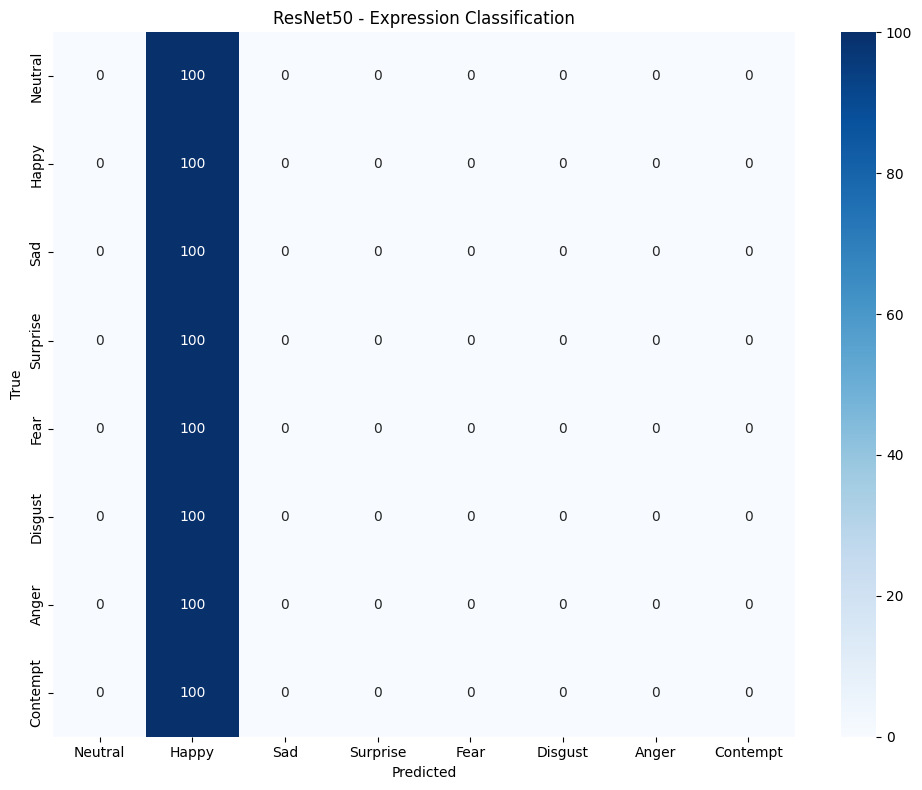

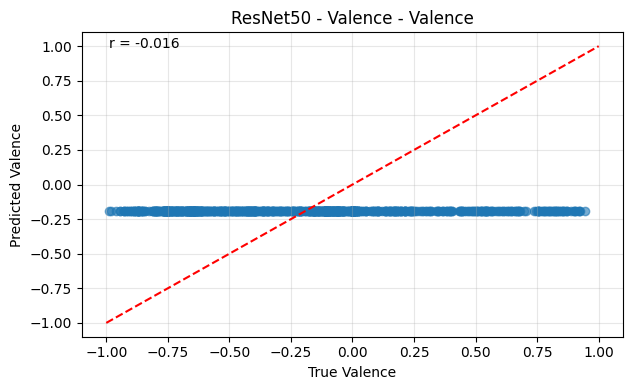

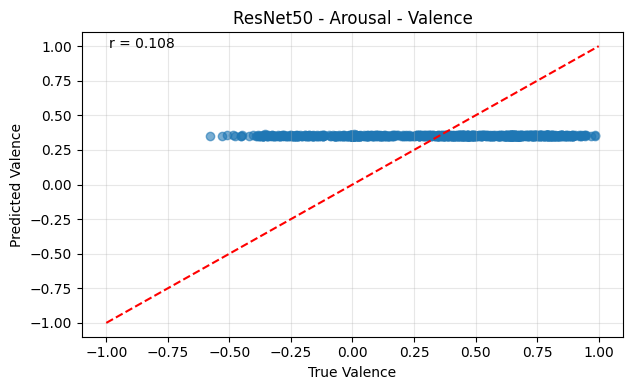


Training VGG16

VGG16 Model Summary:


Model: "VGG16_FER"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 15,175,626 (57.89 MB)

 Trainable params: 460,938 (1.76 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Training VGG16...
Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 402s 5s/step - arousal_output_loss: 0.1900 - arousal_output_mae: 0.3621 - expression_output_accuracy: 0.1293 - expression_output_loss: 2.1155 - loss: 2.3477 - valence_output_loss: 0.2744 - valence_output_mae: 0.4198 - val_arousal_output_loss: 0.1639 - val_arousal_output_mae: 0.3563 - val_expression_output_accuracy: 0.1406 - val_expression_output_loss: 2.0720 - val_loss: 2.2663 - val_valence_output_loss: 0.2247 - val_valence_output_mae: 0.3879 - learning_rate: 0.0010
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 526s 7s/step - arousal_output_loss: 0.1584 - arousal_output_mae: 0.3428 - expression_output_accuracy: 0.1481 - expression_output_loss: 2.0786 - loss: 2.2693 - valence_output_loss: 0.2229 - valence_output_mae: 0.3860 - val_arousal_output_loss: 0.1644 - val_arousal_output_mae: 0.3567 - val_expression_output_accuracy: 0.1703 - val_expression_output_loss: 2.0615 - val_loss: 2.2599 - val_valence_output_loss: 0.2324 - val_valence_output

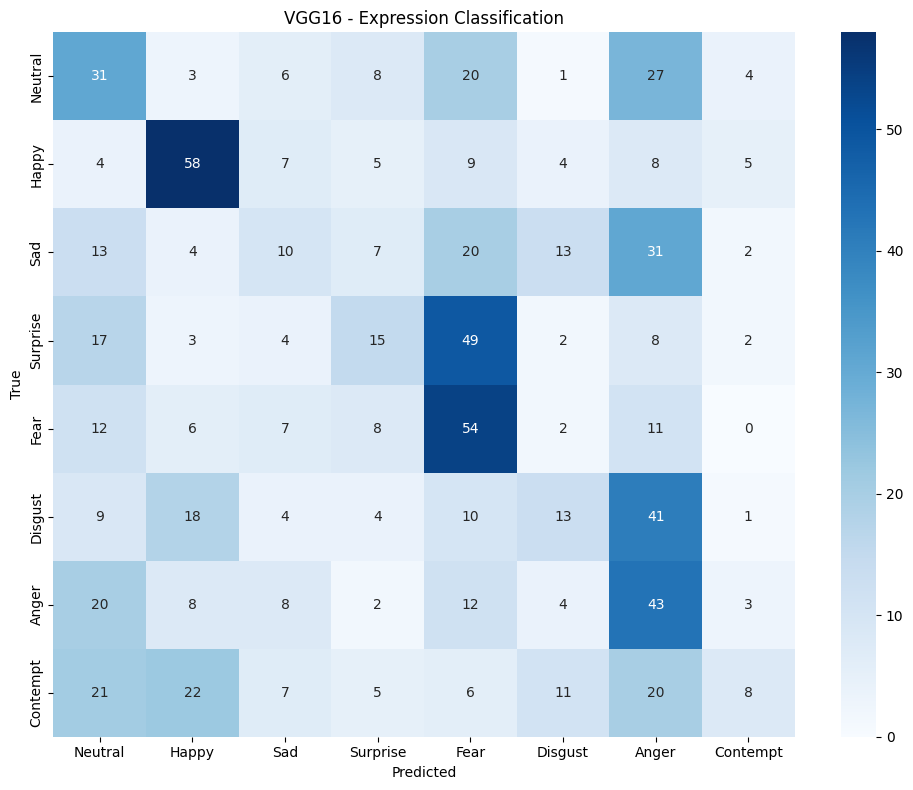

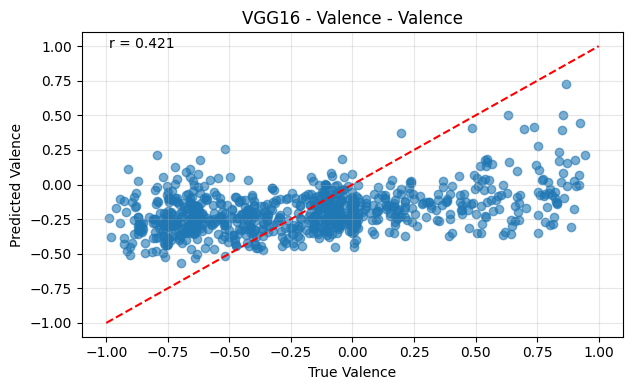

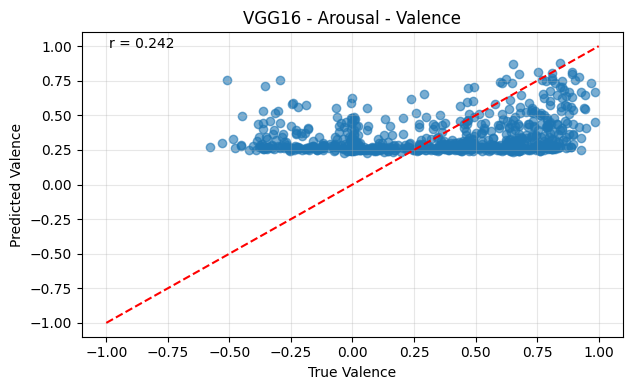


MODEL COMPARISON SUMMARY

Expression Classification Metrics:
               ResNet50   VGG16
Accuracy         0.1250  0.2900
F1-Score         0.0278  0.2632
Cohen's Kappa    0.0000  0.1886
AUC              0.4986  0.7236

Valence Regression Metrics:
             ResNet50   VGG16
RMSE           0.4705  0.4288
Correlation   -0.0163  0.4215
SAGR           0.6938  0.7150
CCC           -0.0000  0.2512

Arousal Regression Metrics:
             ResNet50   VGG16
RMSE           0.3738  0.3648
Correlation    0.1078  0.2421
SAGR           0.7738  0.7738
CCC            0.0009  0.1440


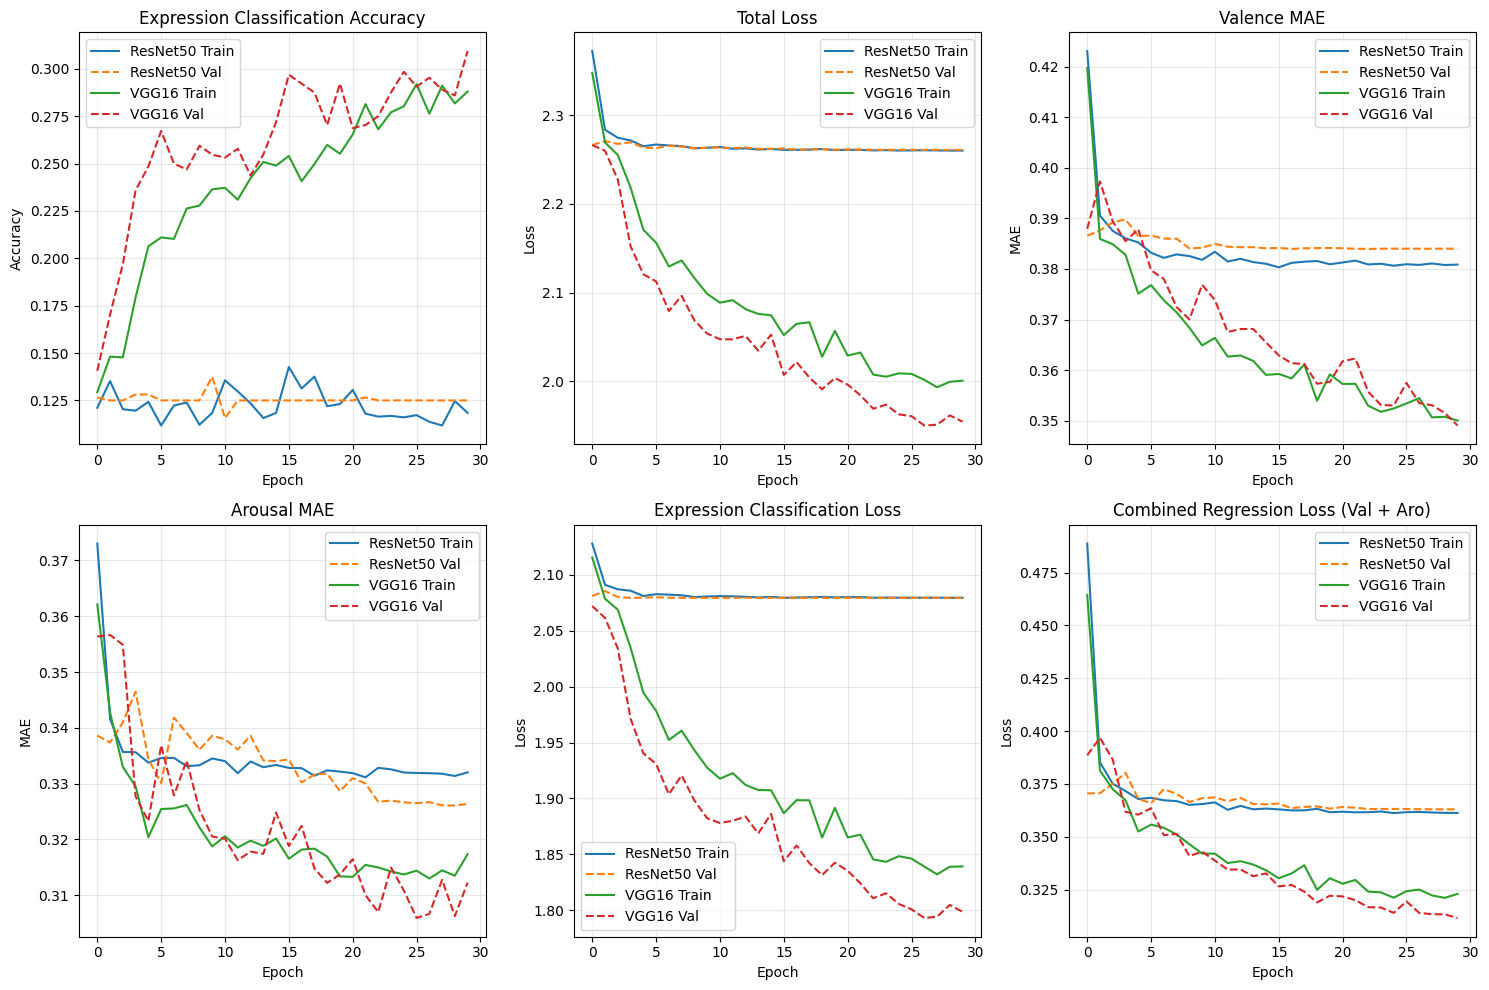


QUALITATIVE RESULTS
Best model: VGG16
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


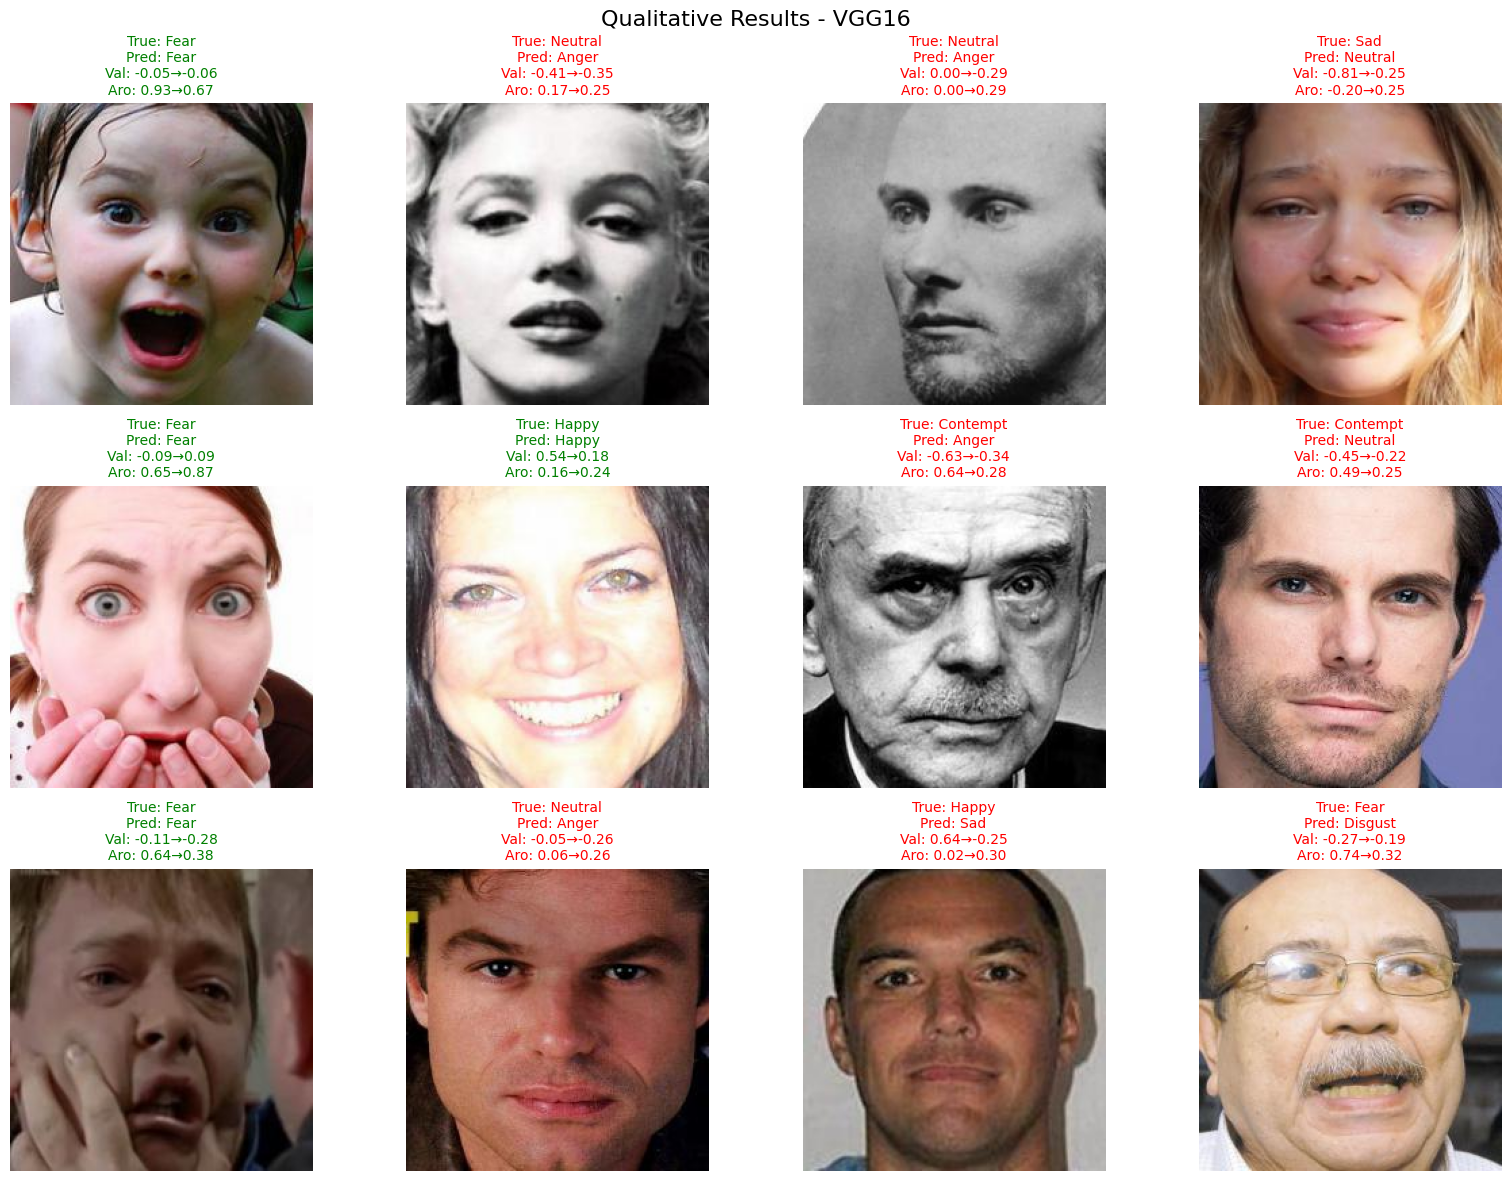


Analysis of Expression Classification:
22/25 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step

In [ ]:
def main():
    """Main execution function"""
    
    # Configuration
    DATASET_PATH = 'dataset'  # Update this path
    MAX_SAMPLES = None  # Set to None to load all samples
    EPOCHS = 30
    BATCH_SIZE = 32
    
    print("=== Facial Expression Recognition with Multiple CNN Architectures ===")
    print(f"Loading dataset from: {DATASET_PATH}")
    
    # Load dataset
    data_processor = FERDataProcessor(DATASET_PATH)
    X, y_exp, y_val, y_aro, image_ids = data_processor.load_dataset(max_samples=MAX_SAMPLES)
    
    print(f"Dataset shape: {X.shape}")
    print(f"Expression distribution: {np.bincount(y_exp)}")
    print(f"Valence range: [{np.min(y_val):.3f}, {np.max(y_val):.3f}]")
    print(f"Arousal range: [{np.min(y_aro):.3f}, {np.max(y_aro):.3f}]")
    
    # Split dataset
    X_train, X_test, y_exp_train, y_exp_test, y_val_train, y_val_test, y_aro_train, y_aro_test = \
        train_test_split(X, y_exp, y_val, y_aro, test_size=0.2, random_state=42, stratify=y_exp)
    
    X_train, X_val, y_exp_train, y_exp_val, y_val_train, y_val_val, y_aro_train, y_aro_val = \
        train_test_split(X_train, y_exp_train, y_val_train, y_aro_train, 
                         test_size=0.2, random_state=42, stratify=y_exp_train)
    
    print(f"Train samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    
    # Initialize models with error handling
    models = {}
    
    print("Initializing models...")
    
    try:
        print("Creating ResNet50 model...")
        models['ResNet50'] = ResNetFER()
        print("✓ ResNet50 model created successfully")
    except Exception as e:
        print(f"✗ Error creating ResNet50 model: {e}")
        
    try:
        print("Creating EfficientNetB0 model...")  
        models['EfficientNetB0'] = EfficientNetFER()
        print("✓ EfficientNetB0 model created successfully")
    except Exception as e:
        print(f"✗ Error creating EfficientNetB0 model: {e}")
        
    try:
        print("Creating VGG16 model...")
        models['VGG16'] = VGGNetFER()
        print("✓ VGG16 model created successfully")
    except Exception as e:
        print(f"✗ Error creating VGG16 model: {e}")
    
    if not models:
        print("❌ No models could be initialized. Please check your TensorFlow installation.")
        return None
        
    print(f"Successfully initialized {len(models)} models: {list(models.keys())}")
    
    # Initialize evaluator
    evaluator = FEREvaluator(data_processor.expression_labels)
    
    # Store results
    results = {}
    
    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name}")
        print(f"{'='*50}")
        
        # Preprocess data
        X_train_proc, y_exp_train_cat, y_val_train_proc, y_aro_train_proc = \
            model.preprocess_data(X_train, y_exp_train, y_val_train, y_aro_train)
        X_val_proc, y_exp_val_cat, y_val_val_proc, y_aro_val_proc = \
            model.preprocess_data(X_val, y_exp_val, y_val_val, y_aro_val)
        X_test_proc, y_exp_test_cat, y_val_test_proc, y_aro_test_proc = \
            model.preprocess_data(X_test, y_exp_test, y_val_test, y_aro_test)
        
        # Compile model
        model.compile_model()
        
        # Print model summary
        print(f"\n{model_name} Model Summary:")
        model.model.summary()
        
        # Train model
        print(f"\nTraining {model_name}...")
        history = model.train(
            X_train_proc, y_exp_train_cat, y_val_train_proc, y_aro_train_proc,
            X_val_proc, y_exp_val_cat, y_val_val_proc, y_aro_val_proc,
            epochs=EPOCHS, batch_size=BATCH_SIZE
        )
        
        # Evaluate on test set
        print(f"\nEvaluating {model_name} on test set...")
        predictions = model.model.predict(X_test_proc)
        
        exp_pred, val_pred, aro_pred = predictions
        
        # Evaluate expression classification
        exp_metrics = evaluator.evaluate_categorical(y_exp_test_cat, exp_pred)
        
        # Evaluate valence regression
        val_metrics = evaluator.evaluate_continuous(y_val_test_proc, val_pred)
        
        # Evaluate arousal regression
        aro_metrics = evaluator.evaluate_continuous(y_aro_test_proc, aro_pred)
        
        # Store results
        results[model_name] = {
            'expression': exp_metrics,
            'valence': val_metrics,
            'arousal': aro_metrics,
            'history': history.history
        }
        
        # Print results
        print(f"\n{model_name} Results:")
        print(f"Expression Classification:")
        for metric, value in exp_metrics.items():
            if value is not None:
                print(f"  {metric}: {value:.4f}")
        
        print(f"Valence Regression:")
        for metric, value in val_metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        print(f"Arousal Regression:")
        for metric, value in aro_metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # Plot confusion matrix
        evaluator.plot_confusion_matrix(y_exp_test_cat, exp_pred, 
                                      f'{model_name} - Expression Classification')
        
        # Plot regression results
        evaluator.plot_regression_results(y_val_test_proc, val_pred, 
                                        f'{model_name} - Valence')
        evaluator.plot_regression_results(y_aro_test_proc, aro_pred, 
                                        f'{model_name} - Arousal')
    
    # Compare results
    print(f"\n{'='*80}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*80}")
    
    # Create comparison DataFrame for expression classification
    exp_comparison = pd.DataFrame()
    for model_name, result in results.items():
        exp_metrics = result['expression']
        exp_comparison[model_name] = [
            exp_metrics.get('accuracy', 0),
            exp_metrics.get('f1_score', 0),
            exp_metrics.get('cohens_kappa', 0),
            exp_metrics.get('auc', 0) if exp_metrics.get('auc') else 0
        ]
    
    exp_comparison.index = ['Accuracy', 'F1-Score', 'Cohen\'s Kappa', 'AUC']
    print("\nExpression Classification Metrics:")
    print(exp_comparison.round(4))
    
    # Create comparison DataFrame for valence regression
    val_comparison = pd.DataFrame()
    for model_name, result in results.items():
        val_metrics = result['valence']
        val_comparison[model_name] = [
            val_metrics['rmse'],
            val_metrics['correlation'],
            val_metrics['sagr'],
            val_metrics['ccc']
        ]
    
    val_comparison.index = ['RMSE', 'Correlation', 'SAGR', 'CCC']
    print("\nValence Regression Metrics:")
    print(val_comparison.round(4))
    
    # Create comparison DataFrame for arousal regression
    aro_comparison = pd.DataFrame()
    for model_name, result in results.items():
        aro_metrics = result['arousal']
        aro_comparison[model_name] = [
            aro_metrics['rmse'],
            aro_metrics['correlation'],
            aro_metrics['sagr'],
            aro_metrics['ccc']
        ]
    
    aro_comparison.index = ['RMSE', 'Correlation', 'SAGR', 'CCC']
    print("\nArousal Regression Metrics:")
    print(aro_comparison.round(4))
    
    # Plot training history comparison
    plt.figure(figsize=(15, 10))
    
    # Expression accuracy
    plt.subplot(2, 3, 1)
    for model_name, result in results.items():
        plt.plot(result['history']['expression_output_accuracy'], 
                label=f'{model_name} Train')
        plt.plot(result['history']['val_expression_output_accuracy'], 
                label=f'{model_name} Val', linestyle='--')
    plt.title('Expression Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Total loss
    plt.subplot(2, 3, 2)
    for model_name, result in results.items():
        plt.plot(result['history']['loss'], label=f'{model_name} Train')
        plt.plot(result['history']['val_loss'], label=f'{model_name} Val', linestyle='--')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Valence MAE
    plt.subplot(2, 3, 3)
    for model_name, result in results.items():
        plt.plot(result['history']['valence_output_mae'], label=f'{model_name} Train')
        plt.plot(result['history']['val_valence_output_mae'], label=f'{model_name} Val', linestyle='--')
    plt.title('Valence MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Arousal MAE
    plt.subplot(2, 3, 4)
    for model_name, result in results.items():
        plt.plot(result['history']['arousal_output_mae'], label=f'{model_name} Train')
        plt.plot(result['history']['val_arousal_output_mae'], label=f'{model_name} Val', linestyle='--')
    plt.title('Arousal MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Expression loss
    plt.subplot(2, 3, 5)
    for model_name, result in results.items():
        plt.plot(result['history']['expression_output_loss'], label=f'{model_name} Train')
        plt.plot(result['history']['val_expression_output_loss'], label=f'{model_name} Val', linestyle='--')
    plt.title('Expression Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Combined regression loss (Valence + Arousal)
    plt.subplot(2, 3, 6)
    for model_name, result in results.items():
        combined_loss = np.array(result['history']['valence_output_loss']) + \
                       np.array(result['history']['arousal_output_loss'])
        combined_val_loss = np.array(result['history']['val_valence_output_loss']) + \
                           np.array(result['history']['val_arousal_output_loss'])
        plt.plot(combined_loss, label=f'{model_name} Train')
        plt.plot(combined_val_loss, label=f'{model_name} Val', linestyle='--')
    plt.title('Combined Regression Loss (Val + Aro)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display some qualitative results
    print(f"\n{'='*50}")
    print("QUALITATIVE RESULTS")
    print(f"{'='*50}")
    
    # Choose the best model based on expression accuracy
    best_model_name = max(results.keys(), 
                         key=lambda x: results[x]['expression']['accuracy'])
    best_model = models[best_model_name]
    
    print(f"Best model: {best_model_name}")
    
    # Get predictions for a few test samples
    sample_indices = np.random.choice(len(X_test), 12, replace=False)
    sample_images = X_test[sample_indices]
    sample_exp_true = y_exp_test[sample_indices]
    sample_val_true = y_val_test[sample_indices]
    sample_aro_true = y_aro_test[sample_indices]
    
    # Preprocess samples
    sample_images_proc = sample_images.astype('float32') / 255.0
    
    # Get predictions
    predictions = best_model.model.predict(sample_images_proc)
    exp_pred, val_pred, aro_pred = predictions
    exp_pred_classes = np.argmax(exp_pred, axis=1)
    
    # Plot qualitative results
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(f'Qualitative Results - {best_model_name}', fontsize=16)
    
    for i in range(12):
        row = i // 4
        col = i % 4
        
        ax = axes[row, col]
        ax.imshow(sample_images[i].astype('uint8'))
        ax.axis('off')
        
        # Get true and predicted labels
        true_exp = data_processor.expression_labels[sample_exp_true[i]]
        pred_exp = data_processor.expression_labels[exp_pred_classes[i]]
        
        # Color coding: green for correct, red for incorrect
        color = 'green' if sample_exp_true[i] == exp_pred_classes[i] else 'red'
        
        title = f'True: {true_exp}\nPred: {pred_exp}\n' + \
                f'Val: {sample_val_true[i]:.2f}→{val_pred[i][0]:.2f}\n' + \
                f'Aro: {sample_aro_true[i]:.2f}→{aro_pred[i][0]:.2f}'
        
        ax.set_title(title, fontsize=10, color=color)
    
    plt.tight_layout()
    plt.show()
    
    # Analysis of correctly vs incorrectly classified samples
    print(f"\nAnalysis of Expression Classification:")
    
    # Get all predictions
    all_predictions = best_model.model.predict(X_test_proc)
    all_exp_pred = np.argmax(all_predictions[0], axis=1)
    
    correct_mask = (y_exp_test == all_exp_pred)
    
    print(f"Correctly classified: {np.sum(correct_mask)}/{len(y_exp_test)} ({100*np.mean(correct_mask):.1f}%)")
    
    # Per-class accuracy
    print(f"\nPer-class Accuracy:")
    for class_id, class_name in data_processor.expression_labels.items():
        class_mask = (y_exp_test == class_id)
        if np.sum(class_mask) > 0:
            class_accuracy = np.mean(all_exp_pred[class_mask] == class_id)
            print(f"  {class_name}: {class_accuracy:.3f} ({np.sum(class_mask)} samples)")
    
    # Most confused pairs
    print(f"\nMost Confused Expression Pairs:")
    cm = confusion_matrix(y_exp_test, all_exp_pred)
    
    # Find top 5 confusion pairs (excluding diagonal)
    confusion_pairs = []
    for i in range(len(data_processor.expression_labels)):
        for j in range(len(data_processor.expression_labels)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((i, j, cm[i, j]))
    
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    for i, (true_class, pred_class, count) in enumerate(confusion_pairs[:5]):
        true_name = data_processor.expression_labels[true_class]
        pred_name = data_processor.expression_labels[pred_class]
        print(f"  {i+1}. {true_name} → {pred_name}: {count} times")
    
    # Regression performance analysis
    print(f"\nRegression Performance Analysis:")
    
    val_predictions = all_predictions[1].flatten()
    aro_predictions = all_predictions[2].flatten()
    
    print(f"Valence:")
    print(f"  RMSE: {np.sqrt(np.mean((y_val_test - val_predictions)**2)):.4f}")
    print(f"  Mean Absolute Error: {np.mean(np.abs(y_val_test - val_predictions)):.4f}")
    print(f"  Correlation: {pearsonr(y_val_test, val_predictions)[0]:.4f}")
    
    print(f"Arousal:")
    print(f"  RMSE: {np.sqrt(np.mean((y_aro_test - aro_predictions)**2)):.4f}")
    print(f"  Mean Absolute Error: {np.mean(np.abs(y_aro_test - aro_predictions)):.4f}")
    print(f"  Correlation: {pearsonr(y_aro_test, aro_predictions)[0]:.4f}")
    
    # Save results to file
    print(f"\nSaving results...")
    
    # Create results summary
    summary = {
        'dataset_info': {
            'total_samples': len(X),
            'train_samples': len(X_train),
            'val_samples': len(X_val),
            'test_samples': len(X_test),
            'expression_distribution': dict(zip(range(8), np.bincount(y_exp, minlength=8))),
            'valence_range': [float(np.min(y_val)), float(np.max(y_val))],
            'arousal_range': [float(np.min(y_aro)), float(np.max(y_aro))]
        },
        'model_results': {}
    }
    
    for model_name, result in results.items():
        summary['model_results'][model_name] = {
            'expression_metrics': result['expression'],
            'valence_metrics': result['valence'],
            'arousal_metrics': result['arousal']
        }
    
    # Save as JSON
    import json
    with open('fer_results_summary.json', 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    
    print("Results saved to 'fer_results_summary.json'")
    
    print(f"\n{'='*80}")
    print("RECOMMENDATIONS AND CONCLUSIONS")
    print(f"{'='*80}")
    
    # Find best models for each task
    best_exp_model = max(results.keys(), key=lambda x: results[x]['expression']['accuracy'])
    best_val_model = max(results.keys(), key=lambda x: results[x]['valence']['correlation'])
    best_aro_model = max(results.keys(), key=lambda x: results[x]['arousal']['correlation'])
    
    print(f"Best Expression Classification Model: {best_exp_model}")
    print(f"  Accuracy: {results[best_exp_model]['expression']['accuracy']:.4f}")
    print(f"  F1-Score: {results[best_exp_model]['expression']['f1_score']:.4f}")
    
    print(f"\nBest Valence Regression Model: {best_val_model}")
    print(f"  Correlation: {results[best_val_model]['valence']['correlation']:.4f}")
    print(f"  RMSE: {results[best_val_model]['valence']['rmse']:.4f}")
    
    print(f"\nBest Arousal Regression Model: {best_aro_model}")
    print(f"  Correlation: {results[best_aro_model]['arousal']['correlation']:.4f}")
    print(f"  RMSE: {results[best_aro_model]['arousal']['rmse']:.4f}")
    
    print(f"\nRecommendations for Improvement:")
    print("1. Fine-tune the pre-trained models for better feature extraction")
    print("2. Implement advanced data augmentation techniques")
    print("3. Try ensemble methods combining multiple architectures")
    print("4. Experiment with different loss weighting strategies")
    print("5. Consider using attention mechanisms for better feature focus")
    print("6. Implement curriculum learning starting with easier samples")
    
    print(f"\nAnalysis Complete!")
    return results

# Execute the main function
if __name__ == "__main__":
    # Note: Update DATASET_PATH to your actual dataset location
    results = main()